In [36]:
import seaborn as sns
from utils.k_means import KMeans, Cluster
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from skimage.color import rgb2gray, rgb2lab, lab2rgb
from utils.preprocessing import read_image_colorspaces, flatten_image, prepare_training_data
from utils.naive_mapping import apply_naive_mapping
from utils.nn import NeuralNet
import numpy as np
%matplotlib inline
import os
from sklearn.datasets import fetch_mldata
from tqdm import tqdm_notebook

## We can use K-Means to extract a color palette from an image

In [77]:
# Read image into various colorspaces
rgb, lab, grayscale = read_image_colorspaces('data/train/390_128.jpg')

### Flatten Image

In [78]:
rgb_flattened = flatten_image(rgb)
print(rgb_flattened.shape)

lab_flattened = flatten_image(lab)
print(lab_flattened.shape)

grayscale_flattened = flatten_image(grayscale)
print(grayscale_flattened.shape)

(16384, 3)
(16384, 3)
(16384, 1)


### Choose cluster size

In [79]:
n_colors = 32
n_training_samples = 10
n_testing_samples = 5

### Build K-Means models for each colorspace

In [59]:
%%time
kmeans_rgb = KMeans(n_clusters=n_colors)
kmeans_rgb.fit(rgb_flattened)


kmeans_lab = KMeans(n_clusters=n_colors)
kmeans_lab.fit(lab_flattened)


kmeans_grayscale = KMeans(n_clusters=n_colors)
kmeans_grayscale.fit(grayscale_flattened)

CPU times: user 21.8 s, sys: 13.3 ms, total: 21.8 s
Wall time: 21.9 s


In [80]:
rgb_transformed = np.array(kmeans_rgb.transform(rgb_flattened)).reshape(rgb.shape)
lab_transformed = np.array(kmeans_lab.transform(lab_flattened)).reshape(lab.shape)
grayscale_transformed = np.array(kmeans_grayscale.transform(grayscale_flattened)).reshape(grayscale.shape)

### Visualize Transformed Images

Text(0.5, 1.0, 'Grayscale Original')

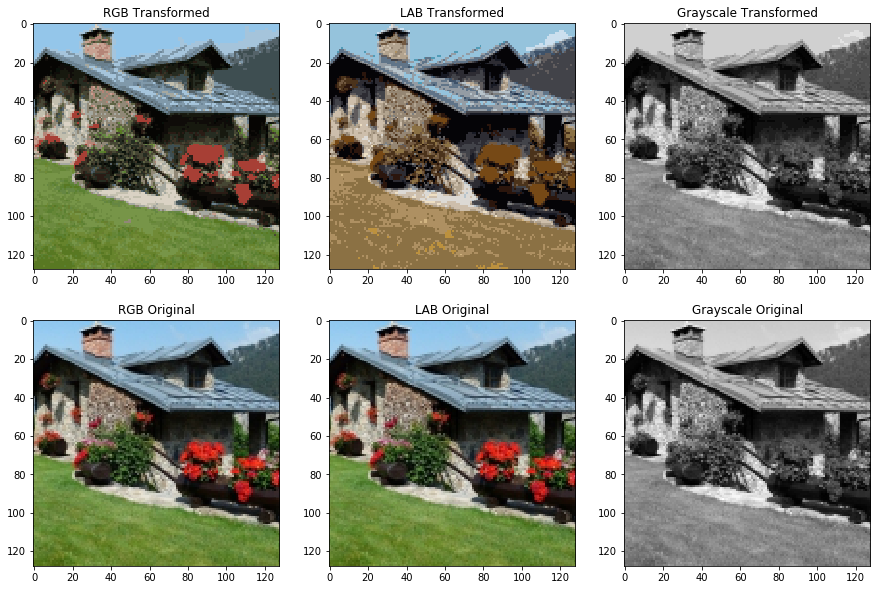

In [81]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes[0,0].imshow(rgb_transformed)
axes[0,0].set_title("RGB Transformed")
axes[0,1].imshow(lab2rgb(lab_transformed))
axes[0,1].set_title("LAB Transformed")
axes[0,2].imshow(grayscale_transformed, cmap='gray')
axes[0,2].set_title("Grayscale Transformed")

axes[1,0].imshow(rgb)
axes[1,0].set_title("RGB Original")
axes[1,1].imshow(lab2rgb(lab))
axes[1,1].set_title("LAB Original")
axes[1,2].imshow(grayscale, cmap='gray')
axes[1,2].set_title("Grayscale Original")

# Naive Approach

Text(0.5, 1.0, 'Naive Grayscale to LAB')

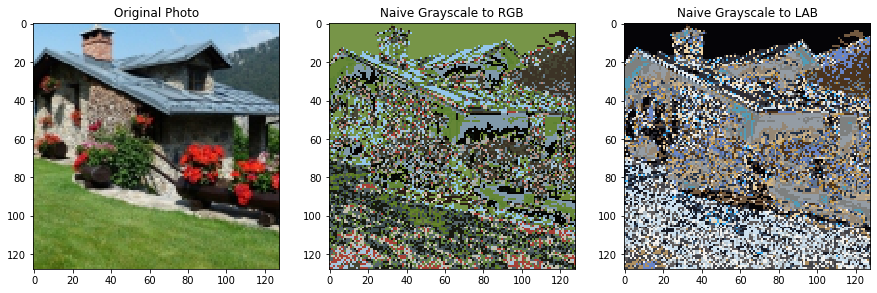

In [82]:
fig, axes = plt.subplots(1, 3, figsize=(15,10))

axes[0].imshow(rgb)
axes[0].set_title("Original Photo")

axes[1].imshow(apply_naive_mapping(kmeans_grayscale, kmeans_rgb, grayscale_transformed))
axes[1].set_title("Naive Grayscale to RGB")

axes[2].imshow(lab2rgb(apply_naive_mapping(kmeans_grayscale, kmeans_lab, grayscale_transformed)))
axes[2].set_title("Naive Grayscale to LAB")

# Build Training Data

### Get Points from Multiple Pictures

In [63]:
# Build K-Means
i = 0

lab_points = []
grayscale_points = []
for filename in os.listdir("data/train"):
    
    if i == n_training_samples:
        break
        
    
    rgb, lab, grayscale = read_image_colorspaces("data/train/"+filename)
    lab_flattened = flatten_image(lab)
    lab_points.append(lab_flattened)

    grayscale_flattened = flatten_image(grayscale)
    grayscale_points.append(grayscale_flattened)

    i += 1
    
grayscale_points = np.stack(grayscale_points, axis=0)
grayscale_points = grayscale_points.reshape(grayscale_points.shape[0]*grayscale_points.shape[1], 1)

lab_points = np.stack(lab_points, axis=0)
lab_points = lab_points.reshape(lab_points.shape[0]*lab_points.shape[1], 3)

print(grayscale_points.shape)
print(lab_points.shape)

(163840, 1)
(163840, 3)


### Build K-Means on Points

In [64]:
%%time
kmeans_grayscale = KMeans(n_clusters=n_colors)
kmeans_grayscale.fit(grayscale_points)

kmeans_lab = KMeans(n_clusters=n_colors)
kmeans_lab.fit(lab_points)

CPU times: user 2min 33s, sys: 686 ms, total: 2min 34s
Wall time: 2min 35s


### Apply Transformations on Pictures

In [65]:
%%time
i = 0

input_images = []
output_images = []

for filename in os.listdir("data/train"):
    
    if i == n_training_samples:
        break
        
    rgb, lab, grayscale = read_image_colorspaces("data/train/"+filename)
    
    lab_flattened = flatten_image(lab)
    lab_transformed = np.array(kmeans_lab.transform(lab_flattened)).reshape(lab.shape)
    
    grayscale_flattened = flatten_image(grayscale)
    grayscale_transformed = np.array(kmeans_grayscale.transform(grayscale_flattened)).reshape(grayscale.shape)
    
    input_images.append(grayscale_transformed)
    output_images.append(lab_transformed)
    
    i += 1
    
input_images = np.array(input_images)
output_images = np.array(output_images)

CPU times: user 24.9 s, sys: 115 ms, total: 25 s
Wall time: 25.2 s


In [66]:
print(input_images.shape)
print(output_images.shape)

(10, 128, 128)
(10, 128, 128, 3)


# Preprocess Training Data

In [67]:
x_train, y_rgb_train = prepare_training_data(input_images, output_images)
print(x_train.shape)
print(y_rgb_train.shape)

(10, 1, 16384)
(10, 16384)


# Training

In [68]:
center_labels = [','.join(str(val) for val in pixel) for pixel in kmeans_lab.get_centers()]
print(center_labels)

['1.4373590706402346,0.4751994953257586,-0.7547445504884931', '18.74185807104268,2.0202174009693135,-3.8400605061463553', '87.92599782343542,-3.672509207591691,-9.377629264164138', '56.28163410967464,7.752795514261903,-37.53715815663387', '9.824509104678137,1.7972211621958614,-6.917062635696761', '61.81340415058733,4.805623604712104,28.861055239267422', '23.651054388014956,7.87184291778386,19.38652273780616', '74.77045870177041,3.658399415220907,29.895450653384586', '39.78016346295499,6.6354841771149555,18.268512490796063', '28.78917525255567,0.7567967663726709,-3.787508909006067', '76.49610969328214,-9.211350156506317,-17.427200807949088', '56.94943976963525,2.4116367400176304,12.561944218467275', '64.27263553791201,-1.373337784664824,-5.226907021157276', '84.81492339516507,2.337193817048109,25.722283263583396', '49.25749289818571,4.253110700073527,28.336027795875825', '34.32870648929478,-1.0241899118293452,-15.734506478356787', '53.55188457448961,-0.7575505353363465,0.077833728690926

In [69]:
network = NeuralNet(1, 128, n_colors, 1, center_labels)

In [70]:
print(y_rgb_train.shape)
print(x_train.shape)

(10, 16384)
(10, 1, 16384)


In [71]:
network.fit(x_train, y_rgb_train, epochs=200)

Epoch 0 cost:  6.3822771303163695
Epoch 10 cost:  3.600785173024364
Epoch 20 cost:  3.3425241291937615
Epoch 30 cost:  3.1898963924277415
Epoch 40 cost:  3.0846890909994484
Epoch 50 cost:  3.0050048458244207
Epoch 60 cost:  2.9409180520876257
Epoch 70 cost:  2.887202018001154
Epoch 80 cost:  2.8408131209982397
Epoch 90 cost:  2.799853001605295
Epoch 100 cost:  2.763079171692285
Epoch 110 cost:  2.729647485243401
Epoch 120 cost:  2.6989649092169494
Epoch 130 cost:  2.6706007758340533
Epoch 140 cost:  2.6442316570719298
Epoch 150 cost:  2.619606543609927
Epoch 160 cost:  2.59652461146478
Epoch 170 cost:  2.5748208919249773
Epoch 180 cost:  2.5543569286770413
Epoch 190 cost:  2.535014584827272

Final cost: 2.5184808557869576


# Predicting

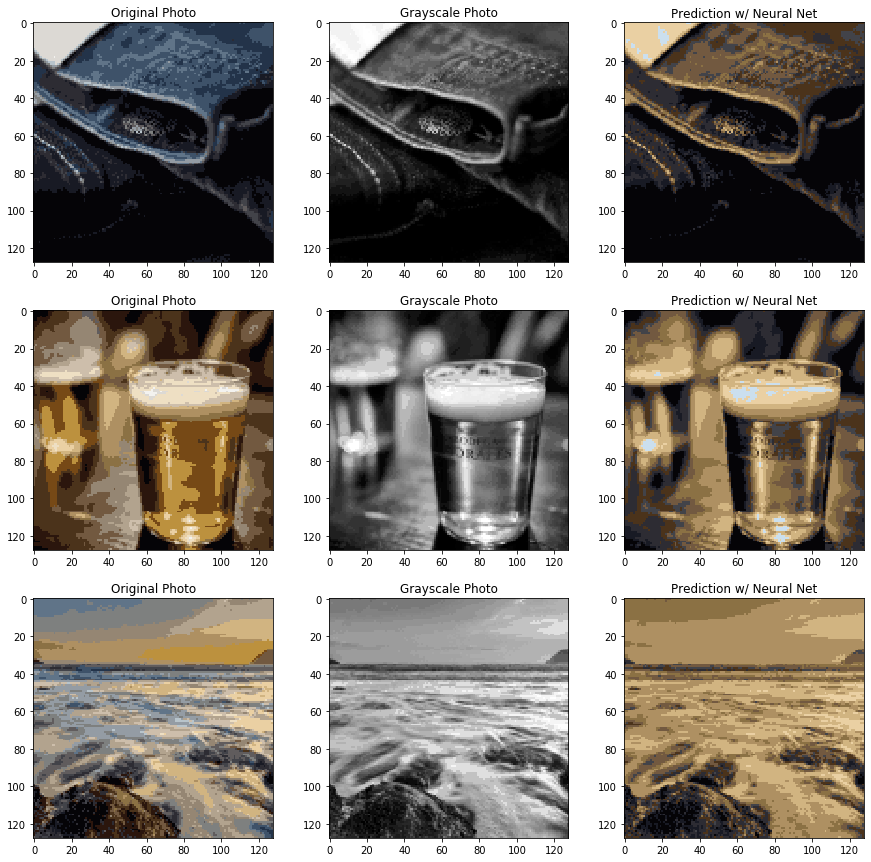

In [72]:
fig, axes = plt.subplots(3, 3, figsize=(15,15))

for i in range(3):
    
    predicted_image = np.array(network.predict(x_train[i], y_rgb_train[i])).reshape(128,128,3)
    
    axes[i, 0 ].imshow(lab2rgb(output_images[i]))
    axes[i, 0].set_title("Original Photo")

    axes[i, 1].imshow(input_images[i], cmap='gray')
    axes[i, 1].set_title("Grayscale Photo")

    axes[i, 2].imshow(lab2rgb(predicted_image))
    axes[i, 2].set_title("Prediction w/ Neural Net")

# Generalize

In [73]:
%%time
i = 0

input_images = []
output_images = []

for filename in os.listdir("data/test"):
    
    if i == n_testing_samples:
        break
        
    rgb, lab, grayscale = read_image_colorspaces("data/test/"+filename)
    
    lab_flattened = flatten_image(lab)
    lab_transformed = np.array(kmeans_lab.transform(lab_flattened)).reshape(lab.shape)
    
    grayscale_flattened = flatten_image(grayscale)
    grayscale_transformed = np.array(kmeans_grayscale.transform(grayscale_flattened)).reshape(grayscale.shape)
    
    input_images.append(grayscale_transformed)
    output_images.append(lab_transformed)
    
    i += 1
    
input_images = np.array(input_images)
output_images = np.array(output_images)

CPU times: user 12.2 s, sys: 35.1 ms, total: 12.2 s
Wall time: 12.3 s


In [74]:
x_test, y_rgb_test = prepare_training_data(input_images, output_images)
print(x_test.shape)
print(y_rgb_test.shape)

(5, 1, 16384)
(5, 16384)


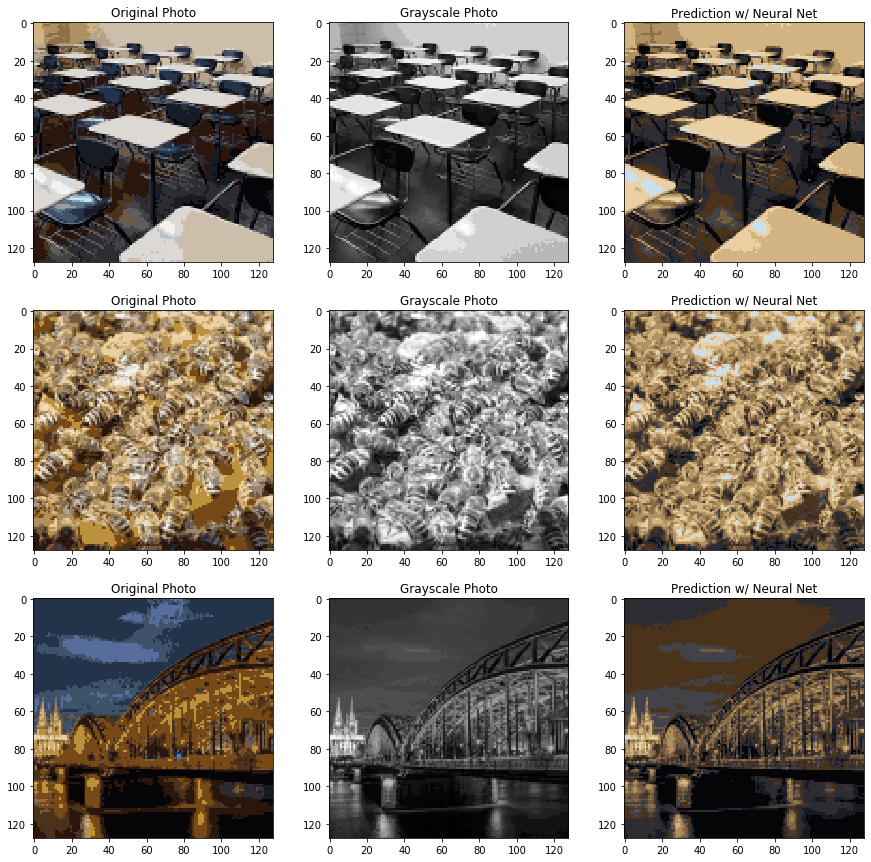

In [75]:
fig, axes = plt.subplots(3, 3, figsize=(15,15))

for i in range(3):
    
    predicted_image = np.array(network.predict(x_test[i], y_rgb_test[i])).reshape(128,128,3)
    
    axes[i, 0 ].imshow(lab2rgb(output_images[i]))
    axes[i, 0].set_title("Original Photo")

    axes[i, 1].imshow(input_images[i], cmap='gray')
    axes[i, 1].set_title("Grayscale Photo")

    axes[i, 2].imshow(lab2rgb(predicted_image))
    axes[i, 2].set_title("Prediction w/ Neural Net")